In [2]:
import pickle
import textwrap
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils
from torch.optim import SGD, Adam, RMSprop
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, Subset
from torchtext.vocab import Vocab

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cpu


In [3]:
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed * 13 // 7)

In [0]:
#Coding is done on google colab
storage_path = '/content/drive/My Drive/MMS_Speech_Language_Modelling/'

In [4]:
#Loading the files
with open ('corpus_clean.txt', "r") as myfile:
    clean_corpus = myfile.read()

with open ('corpus_raw.txt', "r") as myfile:
    raw_corpus = myfile.read()

with open('embed_5k.pickle', 'rb') as handle:
    embed_5k = pickle.load(handle)
    
with open('vocab_5k.pickle', 'rb') as handle:
    vocab_5k = pickle.load(handle)

In [5]:
def create_vocab(corpus_counter, embeddings):
    """Creates vocabulary

    Args:
        corpus_counter (Counter): Counter object with words in vocab and their count
        embeddings (dictionary): Dictionary mapping a word to its embedding

    Returns:
        torchtext Vocab object: Vocab which contains information on mapping strings to ids and ids to embeddings
    """
    vocab = Vocab(corpus_counter, specials=["<unk>"])

    unk_embedding = torch.tensor(sum(list(embeddings.values())) / len(embeddings))
    unk_embedding = torch.zeros_like(unk_embedding)
    embedding_size = unk_embedding.shape[0]

    id2embed = {}
    id2str = []
    str2id = {}

    str2id["<unk>"] = 0
    id2str.append("<unk>")
    id2embed[0] = unk_embedding

    for word, embedding in embeddings.items():
        word_id = len(str2id)
        word_embedding = torch.tensor(embeddings[word])
        str2id[word] = word_id
        id2str.append(word)
        id2embed[word_id] = word_embedding
    vocab.set_vectors(stoi=str2id, vectors=id2embed, dim=embedding_size)
    return vocab

In [6]:
class SpeechDataset(Dataset):
    """MMS speeches dataset. Inherits from Pytorch Dataset"""

    def __init__(self, corpus, vocab, seq_len=25):
        """Initializes the dataset

        Args:
            corpus (string): Corpus text
            vocab (torchtext Vocab): Vocabulary
            seq_len (int, optional): Length of sequence fed to the model. Defaults to 25.
        """
        self.corpus = corpus
        self.vocab = vocab
        self.seq_len = seq_len

        # Splitting corpus to tokens
        self.corpus_list = corpus.split()
        # Converting tokens to ids
        self.corpus_ids = [self.vocab.stoi[word] for word in self.corpus_list]

        # Inputs and outputs are offset by 1
        self.inputs = self.corpus_ids[:-1]
        self.targets = self.corpus_ids[1:]

        # Dividing entire corpus to sequences of length seq_len
        self.input_examples = [
            self.inputs[i : i + self.seq_len]
            for i in range(0, len(self.inputs), self.seq_len)
        ]
        self.target_examples = [
            self.targets[i : i + self.seq_len]
            for i in range(0, len(self.targets), self.seq_len)
        ]

    def __len__(self):
        """Calculates dataset size

        Returns:
            int: Length of dataset
        """
        return len(self.input_examples)

    def __getitem__(self, idx):
        """Returns a sample of dataset whose index is idx

        Args:
            idx (int): Index

        Returns:
            tuple of Tensors: Returns input and output Tensors for a single sample
        """
        return (
            torch.tensor(self.input_examples[idx]),
            torch.tensor(self.target_examples[idx]),
        )


Things which can be improved - Language models learn better when they are fed contigous text. But here we did not define how to sample from dataset to create a batch. So, dataloader selects the sample by random or by in order which is not the optimum way. We need to ensure that consecutive sequences must be fed in separate batches but their position within a batch must be same. So, the first sample within first 3 batches must be seq1,seq2,seq3; and the second sample within first 3 batches must be seqn,seqn+1,seqn+2 where n is the number of batches which can be created for a given dataset and given batch size. Refer AWD-LSTM paper of salesforce for still better way of creating batches


In [7]:
def create_train_val_datasets(dataset, split_ratio=0.99):
    """Splits the dataset into training and validation sets

    Args:
        dataset (Pytorch Dataset): Complete dataset
        split_ratio (float, optional): Fraction of training dataset. Defaults to 0.99.

    Returns:
        tuple of pytorch datasets: Training and validation datasets
    """
    data_size = len(dataset)
    # Calculating the index where to split the training and validation set
    split_point = round(data_size * split_ratio)
    data_ids = list(range(data_size))
    train_ids = data_ids[:split_point]
    val_ids = data_ids[split_point:]

    # Subset function extracts those samples whose index are in ids and packs those sample into another dataset
    train_set = Subset(dataset, train_ids)
    val_set = Subset(dataset, val_ids)

    return (train_set, val_set)


#### Huge scope for improvement here - Here I have assigned the hidden size of lstm as the vocab size. This is not exactly wrong but not optimum. I think the best way is to have hidden size as a fraction of embedding size and then pass the recurrent network output through a linear layer  to get the scores 

In [8]:
class LSTM_one_layer_Model(nn.Module):
    def __init__(self, vocab):
      
        super(LSTM_one_layer_Model, self).__init__()
        self.vocab_size,self.embed_size = vocab.vectors.shape
        #Initializing embedding layer from pretrained vectors and freezing the layer
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors,freeze = True)
        self.lstm = nn.LSTM(input_size = self.embed_size, hidden_size  = self.vocab_size,batch_first = True)
        
    def forward(self,batch,states = None):
       
        batch_size,_ = batch.shape
        #Initializing the states if not passed
        if states == None:
            h =  torch.zeros(1,batch_size,self.vocab_size).to(device)
            c = torch.zeros(1,batch_size,self.vocab_size).to(device)
            states = (h,c)
    
        X =  self.embedding(batch)
        scores,states = self.lstm(X,states)
        return scores,states

In [9]:
class LSTM_two_layer_Model(nn.Module):
    def __init__(self, vocab):
      
        super(LSTM_two_layer_Model, self).__init__()
        self.vocab_size,self.embed_size = vocab.vectors.shape
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors,freeze = True )
        self.lstm = nn.LSTM(input_size = self.embed_size, hidden_size  = self.vocab_size,num_layers  = 2,batch_first = True)
        
    def forward(self,batch,states = None):
       
        batch_size,_ = batch.shape 
        if states == None:
            h =  torch.zeros(2,batch_size,self.vocab_size).to(device)
            c = torch.zeros(2,batch_size,self.vocab_size).to(device)
            states = (h,c)
    
        X =  self.embedding(batch)
        scores,states = self.lstm(X,states)
        return scores,states

In [10]:
class GRU_one_layer_Model(nn.Module):
    def __init__(self, vocab):
      
        super(GRU_one_layer_Model, self).__init__()
        self.vocab_size,self.embed_size = vocab.vectors.shape
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors,freeze = True )
        self.gru = nn.GRU(input_size = self.embed_size, hidden_size  = self.vocab_size,batch_first = True)
        
    def forward(self,batch,states = None):
       
        batch_size,_ = batch.shape 
        if states == None:
            h =  torch.zeros(1,batch_size,self.vocab_size).to(device)
            states = h
    
        X =  self.embedding(batch)
        scores,states = self.gru(X,states)
        return scores,states

In [11]:
class GRU_two_layer_Model(nn.Module):
    def __init__(self, vocab):
      
        super(GRU_two_layer_Model, self).__init__()
        self.vocab_size,self.embed_size = vocab.vectors.shape
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors,freeze = True )
        self.gru = nn.GRU(input_size = self.embed_size, hidden_size  = self.vocab_size,batch_first = True,num_layers = 2)
        
    def forward(self,batch,states = None):
       
        batch_size,_ = batch.shape 
        if states == None:
            h =  torch.zeros(2,batch_size,self.vocab_size).to(device)
            states = h
    
        X =  self.embedding(batch)
        scores,states = self.gru(X,states)
        return scores,states

In [12]:
#This function checks whether the embedding of word is correctly fed to the model or not
#This helped me find the error I discussed in the dataset cleaning notebook
def check_embedding(corpus,vocab,model):
    """Checks whether actual word embedding is passed to the layer

    Args:
        corpus (str): corpus
        vocab (torchtext Vocab): vocabulary
        model (Pytorch Model): Language model
    """
    corpus_list = clean_corpus.split()
    words = corpus_list[15:20]
    ids = [vocab.stoi[word] for word in words]
    x_actual = torch.tensor([embed_5k[word] for word in words])
    x_model = model.embedding(torch.tensor(ids))
    print(x_actual[1][:5])
    print(x_model[1][:5])
    print((x_actual-x_model).sum())

In [13]:
vocab_counter = Counter(vocab_5k)
vocab = create_vocab(vocab_counter,embed_5k)
model = LSTM_one_layer_Model(vocab)

In [14]:
check_embedding(clean_corpus,vocab,embed_5k,model)
del model

tensor([-0.1722,  0.1823, -0.2785, -0.0847,  0.2544])
tensor([-0.1722,  0.1823, -0.2785, -0.0847,  0.2544])
tensor(0.)


In [15]:
def overfit_small_batch_testing(
    model,
    optimizer,
    title_suffix=None,
    seq_len=10,
    batch_size=4,
    iterations=1000,
    corpus=clean_corpus,
    vocab=vocab,
):
    """Checks whether model overfits on a small single batch. Helps to figure out
    whether model has adequate capacity

    Args:
        model ( Model): Language model
        optimizer (optimizer): optimizer
        title_suffix (str], optional): Title suffix to be siaplyed in graph. Defaults to None.
        seq_len (int, optional): Length of sequence. Defaults to 10.
        batch_size (int, optional): Batch size. Defaults to 4.
        iterations (int, optional): Number of iterations. Defaults to 1000.
        vocab (torchtext Vocab, optional): Vocabulary. Defaults to vocab.
    """
    model = model.to(device)
    # creating a batch from dataset
    mms_dataset = SpeechDataset(corpus, vocab, seq_len)
    train_set, val_set = create_train_val_datasets(mms_dataset)
    testing_loader = DataLoader(
        train_set, batch_size=batch_size, shuffle=False, drop_last=True
    )
    feature, target = next(iter(testing_loader))
    feature, target = feature.to(device), target.to(device)

    training_losses = []
    training_iteration = []
    training_accuracy = []

    for i in range(iterations):
        model.train()
        scores, _ = model(feature)
        loss = F.cross_entropy(
            scores.reshape(seq_len * batch_size, -1),
            target.reshape(seq_len * batch_size),
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
        training_iteration.append(i)
        _, predicted_ids = torch.max(scores, dim=2)
        accuracy = np.array((predicted_ids == target).cpu()).mean()
        training_accuracy.append(accuracy)
        if i % 50 == 0:
            print(
                f"Iteration {i}, loss = {round(loss.item(),4)},training accuracy = {round(accuracy,4)}"
            )
        if accuracy == 1:
            break

    plt.style.use("dark_background")
    fig, ax = plt.subplots(figsize=(16, 8), ncols=2)  # ,ncols=2

    ax1 = sns.lineplot(
        x=training_iteration, y=training_losses, label="Training Loss", ax=ax[0]
    )
    ax1.set_xlabel("No. of Iterations", fontsize=15)
    ax1.set_ylabel("Loss", fontsize=15)
    ax1.set_title("Loss", fontsize=18)

    ax2 = sns.lineplot(
        x=training_iteration, y=training_accuracy, label="Training Accuracy", ax=ax[1]
    )
    ax2.set_xlabel("No. of Iterations", fontsize=15)
    ax2.set_ylabel("Accuracy", fontsize=15)
    ax2.set_title("Accuracy", fontsize=18)

    title = f"Seq len = {seq_len}, Batch size = {batch_size} " + title_suffix
    fig.suptitle(title, size=25)
    fig.get_tight_layout()
    fig.show()

Iteration 0, loss = 8.5234,training accuracy = 0.0
Iteration 50, loss = 8.4582,training accuracy = 0.175
Iteration 100, loss = 8.3992,training accuracy = 0.175
Iteration 150, loss = 8.3481,training accuracy = 0.2
Iteration 200, loss = 8.3033,training accuracy = 0.2
Iteration 250, loss = 8.2631,training accuracy = 0.2
Iteration 300, loss = 8.2258,training accuracy = 0.2
Iteration 350, loss = 8.1905,training accuracy = 0.2
Iteration 400, loss = 8.1565,training accuracy = 0.2
Iteration 450, loss = 8.1236,training accuracy = 0.225
Iteration 500, loss = 8.0917,training accuracy = 0.225
Iteration 550, loss = 8.0606,training accuracy = 0.225
Iteration 600, loss = 8.0304,training accuracy = 0.225
Iteration 650, loss = 8.0013,training accuracy = 0.225
Iteration 700, loss = 7.9733,training accuracy = 0.25
Iteration 750, loss = 7.9465,training accuracy = 0.275
Iteration 800, loss = 7.921,training accuracy = 0.275
Iteration 850, loss = 7.8968,training accuracy = 0.325
Iteration 900, loss = 7.874,t

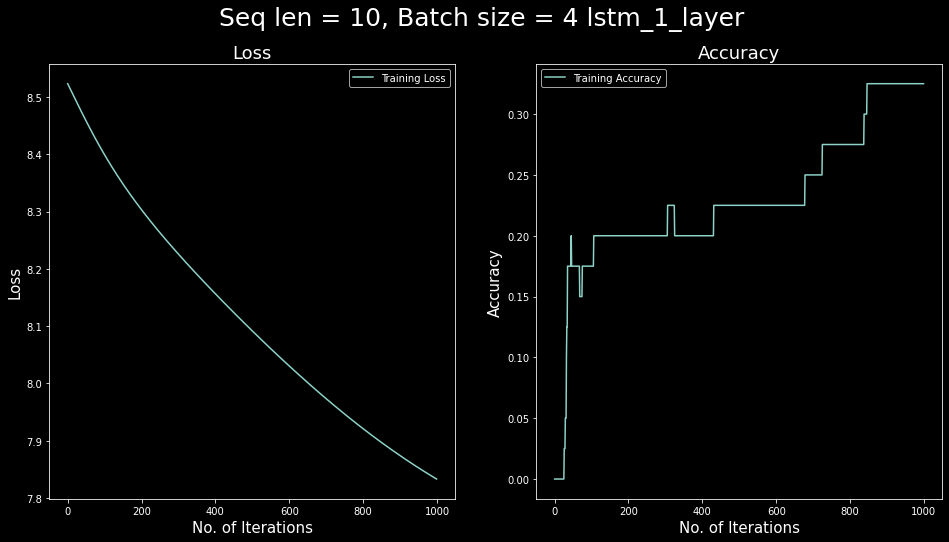

In [0]:
learning_rate = 1e-2
model = LSTM_one_layer_Model(vocab)
optimizer = SGD(model.parameters(), lr=learning_rate)
overfit_small_batch_testing(model,optimizer,title_suffix = 'lstm_1_layer')

Iteration 0, loss = 8.5232,training accuracy = 0.0
Iteration 50, loss = 8.2831,training accuracy = 0.225
Iteration 100, loss = 8.1029,training accuracy = 0.25
Iteration 150, loss = 7.9792,training accuracy = 0.275
Iteration 200, loss = 7.8933,training accuracy = 0.275
Iteration 250, loss = 7.8313,training accuracy = 0.3
Iteration 300, loss = 7.7846,training accuracy = 0.325
Iteration 350, loss = 7.7482,training accuracy = 0.325
Iteration 400, loss = 7.719,training accuracy = 0.35
Iteration 450, loss = 7.6948,training accuracy = 0.35
Iteration 500, loss = 7.6745,training accuracy = 0.35
Iteration 550, loss = 7.6571,training accuracy = 0.325
Iteration 600, loss = 7.642,training accuracy = 0.325
Iteration 650, loss = 7.6287,training accuracy = 0.325
Iteration 700, loss = 7.617,training accuracy = 0.325
Iteration 750, loss = 7.6065,training accuracy = 0.325
Iteration 800, loss = 7.597,training accuracy = 0.325
Iteration 850, loss = 7.5884,training accuracy = 0.325
Iteration 900, loss = 7.5

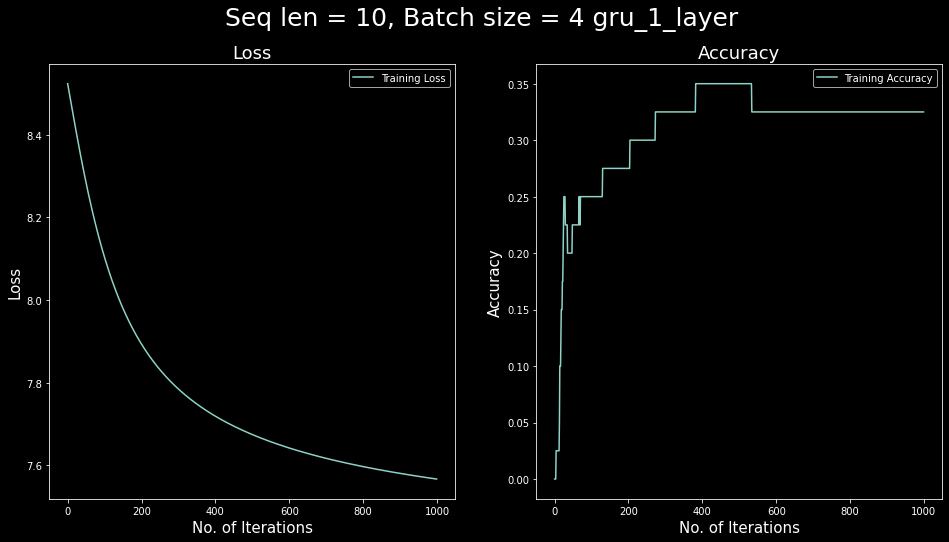

In [0]:
learning_rate = 1e-2
model = GRU_one_layer_Model(vocab)
optimizer = SGD(model.parameters(), lr=learning_rate)
overfit_small_batch_testing(model,optimizer,title_suffix = 'gru_1_layer')

Iteration 0, loss = 8.517,training accuracy = 0.0
Iteration 50, loss = 8.5007,training accuracy = 0.075
Iteration 100, loss = 8.4843,training accuracy = 0.075
Iteration 150, loss = 8.4679,training accuracy = 0.075
Iteration 200, loss = 8.4513,training accuracy = 0.075
Iteration 250, loss = 8.4345,training accuracy = 0.075
Iteration 300, loss = 8.4175,training accuracy = 0.075
Iteration 350, loss = 8.4,training accuracy = 0.075
Iteration 400, loss = 8.3822,training accuracy = 0.075
Iteration 450, loss = 8.364,training accuracy = 0.075
Iteration 500, loss = 8.3453,training accuracy = 0.075
Iteration 550, loss = 8.3261,training accuracy = 0.075
Iteration 600, loss = 8.3065,training accuracy = 0.075
Iteration 650, loss = 8.2863,training accuracy = 0.075
Iteration 700, loss = 8.2657,training accuracy = 0.075
Iteration 750, loss = 8.2445,training accuracy = 0.075
Iteration 800, loss = 8.2226,training accuracy = 0.075
Iteration 850, loss = 8.2,training accuracy = 0.075
Iteration 900, loss = 8

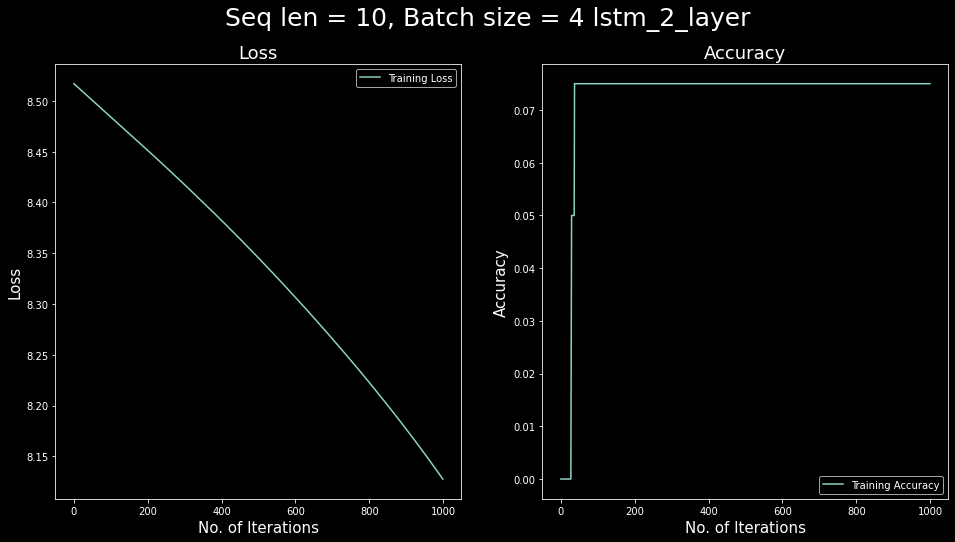

In [0]:
learning_rate = 1e-2
model = LSTM_two_layer_Model(vocab)
optimizer = SGD(model.parameters(), lr=learning_rate)
overfit_small_batch_testing(model,optimizer,title_suffix = 'lstm_2_layer')

Iteration 0, loss = 8.512,training accuracy = 0.0
Iteration 50, loss = 8.3631,training accuracy = 0.1
Iteration 100, loss = 8.2057,training accuracy = 0.1
Iteration 150, loss = 8.0495,training accuracy = 0.1
Iteration 200, loss = 7.9185,training accuracy = 0.125
Iteration 250, loss = 7.8239,training accuracy = 0.15
Iteration 300, loss = 7.759,training accuracy = 0.15
Iteration 350, loss = 7.7132,training accuracy = 0.15
Iteration 400, loss = 7.6794,training accuracy = 0.125
Iteration 450, loss = 7.653,training accuracy = 0.125
Iteration 500, loss = 7.6313,training accuracy = 0.125
Iteration 550, loss = 7.6129,training accuracy = 0.125
Iteration 600, loss = 7.5967,training accuracy = 0.125
Iteration 650, loss = 7.582,training accuracy = 0.125
Iteration 700, loss = 7.5684,training accuracy = 0.125
Iteration 750, loss = 7.5555,training accuracy = 0.125
Iteration 800, loss = 7.543,training accuracy = 0.125
Iteration 850, loss = 7.5308,training accuracy = 0.125
Iteration 900, loss = 7.5186,

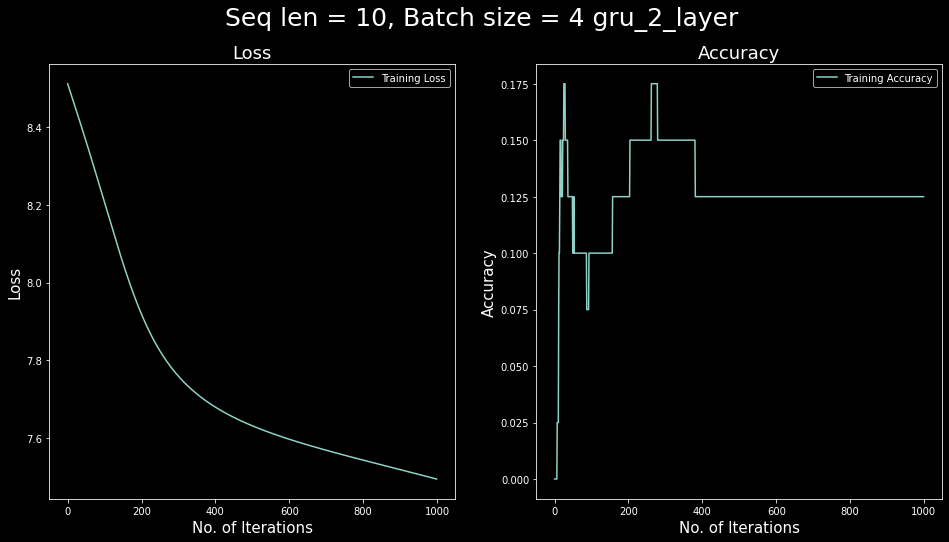

In [0]:
learning_rate = 1e-2
model = GRU_two_layer_Model(vocab)
optimizer = SGD(model.parameters(), lr=learning_rate)
overfit_small_batch_testing(model,optimizer,title_suffix = 'gru_2_layer')

In [16]:
def check_val_loss(model, data_loader, seq_len, batch_size):
    """Validation ste[]

    Args:
        model (Model): Model
        data_loader (Pytorch DataLoader): Validation dataloader
        seq_len (int): Length of sequence
        batch_size (int): Batch size

    Returns:
        tuple of floats: Validation loss and accuracy
    """
    model.eval()
    val_loss = 0
    val_accuracy = 0

    for iteration, (ins, outs) in enumerate(data_loader):
        ins, outs = ins.to(device), outs.to(device)
        scores, states = model(ins)

        loss = F.cross_entropy(
            scores.reshape(seq_len * batch_size, -1), outs.reshape(seq_len * batch_size)
        )
        val_loss += loss

        _, predicted_ids = torch.max(scores, dim=2)
        accuracy = np.array((predicted_ids == outs).cpu()).mean()
        val_accuracy += accuracy
        del ins, outs, scores, states

    val_loss /= iteration + 1
    val_accuracy /= iteration + 1

    return val_loss, val_accuracy


In [17]:
def train(
    model,
    corpus,
    vocab,
    seq_len,
    batch_size,
    epochs,
    optimizer,
    print_every=100,
    check_every=100,
    save=False,
):
    """Function to train the model

    Args:
        model (Pytorch model): Language model
        corpus (string]): Corpus
        vocab (torchtext Vocab): vocabulary
        seq_len (int): length of sequence
        batch_size (int): batch size
        epochs (int): batch size
        optimizer (Pytorch optimizer): optimizer
        print_every (int, optional): how often to print. Defaults to 100.
        check_every (int, optional): how often to validate. Defaults to 100.
        save (bool, optional): Whether to save or not. Defaults to False.

    Returns:
        model: trained model
        dict: training log
    """
    model = model.to(device)

    mms_dataset = SpeechDataset(corpus, vocab, seq_len)
    train_set, val_set = create_train_val_datasets(mms_dataset)

    train_loader = DataLoader(
        train_set, batch_size=batch_size, shuffle=False, drop_last=True
    )
    val_loader = DataLoader(
        val_set, batch_size=batch_size, shuffle=False, drop_last=True
    )
    epoch_len = len(train_loader)
    training_losses = []
    training_iteration = []
    validation_losses = []
    validation_accuracy = []
    training_accuracy = []
    validation_iteration = []

    for epoch in range(epochs):
        print("\n")
        print(f"Running epoch {epoch + 1}")
        print("\n")
        for i, (inputs, targets) in enumerate(train_loader):
            model.train()
            inputs, targets = inputs.to(device), targets.to(device)

            scores, states = model(inputs)
            loss = F.cross_entropy(
                scores.reshape(seq_len * batch_size, -1),
                targets.reshape(seq_len * batch_size),
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % print_every == 0:
                training_losses.append(loss.item())
                training_iteration.append(epoch * epoch_len + i)

                _, predicted_ids = torch.max(scores, dim=2)
                accuracy = np.array((predicted_ids == targets).cpu()).mean()
                training_accuracy.append(accuracy)

                print(
                    f"Iteration {i}, loss = {round(loss.item(),4)},training accuracy = {round(accuracy,4)}"
                )

            del inputs, targets, scores, states

            if i % check_every == 0:
                val_loss, val_accuracy = check_val_loss(
                    model, val_loader, seq_len, batch_size
                )
                validation_losses.append(val_loss.item())
                validation_accuracy.append(val_accuracy)
                validation_iteration.append(epoch * epoch_len + i)
                print(
                    f"Iteration {i}, validation loss = {round(val_loss.item(),4)},validation accuracy = {round(val_accuracy,4)}"
                )

        if save and (epoch + 1) % 10 == 0:
            PATH = storage_path + f"model_epoch_{epoch}.pt"
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": loss,
                },
                PATH,
            )

    training_log = {
        "training_losses": training_losses,
        "training_accuracy": training_accuracy,
        "training_iteration": training_iteration,
        "validation_losses": validation_losses,
        "validation_accuracy": validation_accuracy,
        "validation_iteration": validation_iteration,
        "sequence_length": seq_len,
        "batch_size": batch_size,
        "optimizer_state": optimizer.state_dict()["param_groups"][0],
    }

    return model, training_log


In [18]:
def plot_training_log(training_log, title_suffix=None):
    """Plots training and validation logs and accuracy

    Args:
        training_log (dict): Training log
        title_suffix (str, optional): Name to be displayed on graph. Defaults to None.
    """
    training_losses = training_log["training_losses"]
    training_iteration = training_log["training_iteration"]
    validation_losses = training_log["validation_losses"]
    training_accuracy = training_log["training_accuracy"]
    validation_accuracy = training_log["validation_accuracy"]
    validation_iteration = training_log["validation_iteration"]
    seq_len = training_log["sequence_length"]
    batch_size = training_log["batch_size"]
    learning_rate = training_log["optimizer_state"]["lr"]

    plt.style.use("dark_background")
    fig, ax = plt.subplots(figsize=(16, 8), ncols=2)  # ,ncols=2

    ax1 = sns.lineplot(
        x=training_iteration, y=training_losses, label="Training Loss", ax=ax[0]
    )
    ax1 = sns.lineplot(
        x=validation_iteration, y=validation_losses, label="Validation Loss", ax=ax[0]
    )
    ax1.set_xlabel("No. of Iterations", fontsize=15)
    ax1.set_ylabel("Loss", fontsize=15)
    ax1.set_title("Loss", fontsize=18)

    ax2 = sns.lineplot(
        x=training_iteration, y=training_accuracy, label="Training Accuracy", ax=ax[1]
    )
    ax2 = sns.lineplot(
        x=validation_iteration,
        y=validation_accuracy,
        label="Validation Accuracy",
        ax=ax[1],
    )
    ax2.set_xlabel("No. of Iterations", fontsize=15)
    ax2.set_ylabel("Accuracy", fontsize=15)
    ax2.set_title("Accuracy", fontsize=18)

    title = f"Seq len = {seq_len}, Batch size = {batch_size} " + title_suffix
    fig.suptitle(title, size=25)
    fig.get_tight_layout()
    fig.show()

In [0]:
learning_rate = 1e-1
model = GRU_one_layer_Model(vocab)
optimizer = SGD(model.parameters(), lr=learning_rate)
model_1,training_log_1 = train(model,clean_corpus,vocab,15,32,1,optimizer)



Running epoch 1


Iteration 0, loss = 8.5185,training accuracy = 0.0
Iteration 0, validation loss = 8.5043,validation accuracy = 0.0107
Iteration 50, loss = 8.1914,training accuracy = 0.0292
Iteration 100, loss = 8.0872,training accuracy = 0.0875
Iteration 100, validation loss = 8.0969,validation accuracy = 0.0686
Iteration 150, loss = 8.0292,training accuracy = 0.0604
Iteration 200, loss = 7.9894,training accuracy = 0.0438
Iteration 200, validation loss = 7.9891,validation accuracy = 0.0684
Iteration 250, loss = 7.89,training accuracy = 0.0958
Iteration 300, loss = 7.8652,training accuracy = 0.0833
Iteration 300, validation loss = 7.8869,validation accuracy = 0.0687
Iteration 350, loss = 7.7725,training accuracy = 0.0562
Iteration 400, loss = 7.7589,training accuracy = 0.05
Iteration 400, validation loss = 7.755,validation accuracy = 0.0686
Iteration 450, loss = 7.6384,training accuracy = 0.0812
Iteration 500, loss = 7.5711,training accuracy = 0.0479
Iteration 500, validation loss =

In [0]:
learning_rate = 5e-2
model = GRU_one_layer_Model(vocab)
optimizer = SGD(model.parameters(), lr=learning_rate)
model_2,training_log_2 = train(model,clean_corpus,vocab,15,32,1,optimizer)



Running epoch 1


Iteration 0, loss = 8.5155,training accuracy = 0.0
Iteration 0, validation loss = 8.508,validation accuracy = 0.0066
Iteration 50, loss = 8.2753,training accuracy = 0.0292
Iteration 100, loss = 8.1791,training accuracy = 0.0875
Iteration 100, validation loss = 8.1918,validation accuracy = 0.0683
Iteration 150, loss = 8.1323,training accuracy = 0.0688
Iteration 200, loss = 8.1009,training accuracy = 0.0458
Iteration 200, validation loss = 8.0988,validation accuracy = 0.0688
Iteration 250, loss = 8.0328,training accuracy = 0.0979
Iteration 300, loss = 8.0201,training accuracy = 0.0812
Iteration 300, validation loss = 8.0367,validation accuracy = 0.0692
Iteration 350, loss = 7.982,training accuracy = 0.0562
Iteration 400, loss = 8.0049,training accuracy = 0.0521
Iteration 400, validation loss = 7.9883,validation accuracy = 0.0695
Iteration 450, loss = 7.9218,training accuracy = 0.0833
Iteration 500, loss = 7.9127,training accuracy = 0.0521
Iteration 500, validation los

In [0]:
learning_rate = 1e-2
model = GRU_one_layer_Model(vocab)
optimizer = SGD(model.parameters(), lr=learning_rate)
model_3,training_log_3 = train(model,clean_corpus,vocab,15,32,1,optimizer)



Running epoch 1


Iteration 0, loss = 8.5162,training accuracy = 0.0
Iteration 0, validation loss = 8.51,validation accuracy = 0.0
Iteration 50, loss = 8.4449,training accuracy = 0.0354
Iteration 100, loss = 8.3763,training accuracy = 0.0792
Iteration 100, validation loss = 8.3846,validation accuracy = 0.0697
Iteration 150, loss = 8.3355,training accuracy = 0.0604
Iteration 200, loss = 8.3107,training accuracy = 0.0438
Iteration 200, validation loss = 8.3043,validation accuracy = 0.0676
Iteration 250, loss = 8.2651,training accuracy = 0.0958
Iteration 300, loss = 8.247,training accuracy = 0.0792
Iteration 300, validation loss = 8.254,validation accuracy = 0.068
Iteration 350, loss = 8.2327,training accuracy = 0.0562
Iteration 400, loss = 8.2419,training accuracy = 0.0521
Iteration 400, validation loss = 8.2179,validation accuracy = 0.0683
Iteration 450, loss = 8.1745,training accuracy = 0.0833
Iteration 500, loss = 8.1871,training accuracy = 0.0479
Iteration 500, validation loss = 8.

In [0]:
learning_rate = 5e-3
model = GRU_one_layer_Model(vocab)
optimizer = SGD(model.parameters(), lr=learning_rate)
model_4,training_log_4 = train(model,clean_corpus,vocab,15,32,1,optimizer)



Running epoch 1


Iteration 0, loss = 8.5173,training accuracy = 0.0
Iteration 0, validation loss = 8.5156,validation accuracy = 0.0005
Iteration 50, loss = 8.4837,training accuracy = 0.0333
Iteration 100, loss = 8.44,training accuracy = 0.0812
Iteration 100, validation loss = 8.4457,validation accuracy = 0.0673
Iteration 150, loss = 8.4155,training accuracy = 0.0583
Iteration 200, loss = 8.3912,training accuracy = 0.0417
Iteration 200, validation loss = 8.3853,validation accuracy = 0.0657
Iteration 250, loss = 8.3518,training accuracy = 0.0708
Iteration 300, loss = 8.3345,training accuracy = 0.0708
Iteration 300, validation loss = 8.3401,validation accuracy = 0.0661
Iteration 350, loss = 8.3208,training accuracy = 0.0562
Iteration 400, loss = 8.3233,training accuracy = 0.05
Iteration 400, validation loss = 8.3049,validation accuracy = 0.0665
Iteration 450, loss = 8.2651,training accuracy = 0.0833
Iteration 500, loss = 8.2845,training accuracy = 0.05
Iteration 500, validation loss = 

In [0]:
learning_rate = 1e-3
model = GRU_one_layer_Model(vocab)
optimizer = SGD(model.parameters(), lr=learning_rate)
model_5,training_log_5 = train(model,clean_corpus,vocab,15,32,1,optimizer)



Running epoch 1


Iteration 0, loss = 8.5209,training accuracy = 0.0
Iteration 0, validation loss = 8.5182,validation accuracy = 0.0
Iteration 50, loss = 8.51,training accuracy = 0.0
Iteration 100, loss = 8.5058,training accuracy = 0.0062
Iteration 100, validation loss = 8.5038,validation accuracy = 0.0024
Iteration 150, loss = 8.4981,training accuracy = 0.0146
Iteration 200, loss = 8.4919,training accuracy = 0.0375
Iteration 200, validation loss = 8.4888,validation accuracy = 0.0486
Iteration 250, loss = 8.48,training accuracy = 0.0688
Iteration 300, loss = 8.471,training accuracy = 0.0438
Iteration 300, validation loss = 8.4746,validation accuracy = 0.0599
Iteration 350, loss = 8.4691,training accuracy = 0.0542
Iteration 400, loss = 8.4684,training accuracy = 0.05
Iteration 400, validation loss = 8.4608,validation accuracy = 0.0624
Iteration 450, loss = 8.4441,training accuracy = 0.0771
Iteration 500, loss = 8.4551,training accuracy = 0.0479
Iteration 500, validation loss = 8.4476,

In [0]:
learning_rate = 1e-2
model = GRU_one_layer_Model(vocab)
optimizer = SGD(model.parameters(), lr=learning_rate)
_,training_log_6 = train(model,clean_corpus,vocab,20,32,1,optimizer)



Running epoch 1


Iteration 0, loss = 8.5177,training accuracy = 0.0016
Iteration 0, validation loss = 8.5178,validation accuracy = 0.0002
Iteration 50, loss = 8.4541,training accuracy = 0.0203
Iteration 100, loss = 8.3675,training accuracy = 0.075
Iteration 100, validation loss = 8.3833,validation accuracy = 0.0657
Iteration 150, loss = 8.3411,training accuracy = 0.0422
Iteration 200, loss = 8.2821,training accuracy = 0.0453
Iteration 200, validation loss = 8.2975,validation accuracy = 0.0661
Iteration 250, loss = 8.279,training accuracy = 0.0625
Iteration 300, loss = 8.2649,training accuracy = 0.0531
Iteration 300, validation loss = 8.2447,validation accuracy = 0.0664
Iteration 350, loss = 8.2097,training accuracy = 0.0766
Iteration 400, loss = 8.2097,training accuracy = 0.05
Iteration 400, validation loss = 8.2066,validation accuracy = 0.0671
Iteration 450, loss = 8.2007,training accuracy = 0.0438
Iteration 500, loss = 8.147,training accuracy = 0.1219
Iteration 500, validation los

In [0]:
learning_rate = 1e-2
model = GRU_one_layer_Model(vocab)
optimizer = SGD(model.parameters(), lr=learning_rate)
_,training_log_7 = train(model,clean_corpus,vocab,25,32,1,optimizer)



Running epoch 1


Iteration 0, loss = 8.5188,training accuracy = 0.0
Iteration 0, validation loss = 8.518,validation accuracy = 0.0001
Iteration 50, loss = 8.4508,training accuracy = 0.0488
Iteration 100, loss = 8.3756,training accuracy = 0.0588
Iteration 100, validation loss = 8.3776,validation accuracy = 0.0676
Iteration 150, loss = 8.3125,training accuracy = 0.085
Iteration 200, loss = 8.3013,training accuracy = 0.0662
Iteration 200, validation loss = 8.2905,validation accuracy = 0.0676
Iteration 250, loss = 8.248,training accuracy = 0.05
Iteration 300, loss = 8.2427,training accuracy = 0.05
Iteration 300, validation loss = 8.2358,validation accuracy = 0.0689
Iteration 350, loss = 8.1866,training accuracy = 0.05
Iteration 400, loss = 8.1678,training accuracy = 0.1262
Iteration 400, validation loss = 8.1963,validation accuracy = 0.0697
Iteration 450, loss = 8.1865,training accuracy = 0.06
Iteration 500, loss = 8.1758,training accuracy = 0.0588
Iteration 500, validation loss = 8.165

In [0]:
learning_rate = 1e-2
model = GRU_one_layer_Model(vocab)
optimizer = SGD(model.parameters(), lr=learning_rate)
_,training_log_8 = train(model,clean_corpus,vocab,15,32,2,optimizer)



Running epoch 1


Iteration 0, loss = 8.5181,training accuracy = 0.0
Iteration 0, validation loss = 8.5153,validation accuracy = 0.0002
Iteration 50, loss = 8.4491,training accuracy = 0.0292
Iteration 100, loss = 8.3782,training accuracy = 0.0833
Iteration 100, validation loss = 8.3874,validation accuracy = 0.0693
Iteration 150, loss = 8.3337,training accuracy = 0.0583
Iteration 200, loss = 8.3114,training accuracy = 0.0417
Iteration 200, validation loss = 8.3054,validation accuracy = 0.0686
Iteration 250, loss = 8.2645,training accuracy = 0.0958
Iteration 300, loss = 8.2455,training accuracy = 0.0854
Iteration 300, validation loss = 8.2543,validation accuracy = 0.0688
Iteration 350, loss = 8.2375,training accuracy = 0.0542
Iteration 400, loss = 8.2391,training accuracy = 0.0542
Iteration 400, validation loss = 8.2179,validation accuracy = 0.0691
Iteration 450, loss = 8.1799,training accuracy = 0.0812
Iteration 500, loss = 8.195,training accuracy = 0.0521
Iteration 500, validation lo

In [0]:
learning_rate = 1e-2
model = GRU_one_layer_Model(vocab)
optimizer = SGD(model.parameters(), lr=learning_rate)
_,training_log_9 = train(model,clean_corpus,vocab,20,32,2,optimizer)



Running epoch 1


Iteration 0, loss = 8.5173,training accuracy = 0.0
Iteration 0, validation loss = 8.5158,validation accuracy = 0.0004
Iteration 50, loss = 8.4471,training accuracy = 0.0266
Iteration 100, loss = 8.3631,training accuracy = 0.0781
Iteration 100, validation loss = 8.3808,validation accuracy = 0.0657
Iteration 150, loss = 8.3394,training accuracy = 0.0406
Iteration 200, loss = 8.2789,training accuracy = 0.0484
Iteration 200, validation loss = 8.2958,validation accuracy = 0.0668
Iteration 250, loss = 8.28,training accuracy = 0.0641
Iteration 300, loss = 8.2623,training accuracy = 0.0562
Iteration 300, validation loss = 8.2438,validation accuracy = 0.067
Iteration 350, loss = 8.2106,training accuracy = 0.0766
Iteration 400, loss = 8.2121,training accuracy = 0.05
Iteration 400, validation loss = 8.2064,validation accuracy = 0.0674
Iteration 450, loss = 8.2026,training accuracy = 0.0406
Iteration 500, loss = 8.1448,training accuracy = 0.1203
Iteration 500, validation loss =

In [0]:
learning_rate = 1e-2
model = GRU_one_layer_Model(vocab)
optimizer = SGD(model.parameters(), lr=learning_rate)
model_10,training_log_10 = train(model,clean_corpus,vocab,15,32,4,optimizer,50,100,True)



Running epoch 1


Iteration 0, loss = 8.5186,training accuracy = 0.0
Iteration 0, validation loss = 8.5185,validation accuracy = 0.0001
Iteration 50, loss = 8.4523,training accuracy = 0.0229
Iteration 100, loss = 8.3786,training accuracy = 0.0771
Iteration 100, validation loss = 8.3892,validation accuracy = 0.0672
Iteration 150, loss = 8.3354,training accuracy = 0.0604
Iteration 200, loss = 8.3171,training accuracy = 0.0438
Iteration 200, validation loss = 8.3058,validation accuracy = 0.0675
Iteration 250, loss = 8.2645,training accuracy = 0.0979
Iteration 300, loss = 8.2452,training accuracy = 0.0792
Iteration 300, validation loss = 8.2543,validation accuracy = 0.0677
Iteration 350, loss = 8.2318,training accuracy = 0.0562
Iteration 400, loss = 8.2412,training accuracy = 0.05
Iteration 400, validation loss = 8.2178,validation accuracy = 0.0681
Iteration 450, loss = 8.1772,training accuracy = 0.0812
Iteration 500, loss = 8.1914,training accuracy = 0.05
Iteration 500, validation loss 

In [0]:
learning_rate = 1e-2
model = GRU_one_layer_Model(vocab)
optimizer = SGD(model.parameters(), lr=learning_rate)
model_11,training_log_11 = train(model,clean_corpus,vocab,15,32,8,optimizer,50,100,True)



Running epoch 1


Iteration 0, loss = 8.5184,training accuracy = 0.0021
Iteration 0, validation loss = 8.5164,validation accuracy = 0.0003
Iteration 50, loss = 8.4472,training accuracy = 0.0354
Iteration 100, loss = 8.3826,training accuracy = 0.0792
Iteration 100, validation loss = 8.3881,validation accuracy = 0.068
Iteration 150, loss = 8.3403,training accuracy = 0.0583
Iteration 200, loss = 8.3103,training accuracy = 0.0438
Iteration 200, validation loss = 8.3054,validation accuracy = 0.0675
Iteration 250, loss = 8.2621,training accuracy = 0.0958
Iteration 300, loss = 8.2445,training accuracy = 0.0812
Iteration 300, validation loss = 8.2543,validation accuracy = 0.0682
Iteration 350, loss = 8.2323,training accuracy = 0.0562
Iteration 400, loss = 8.2398,training accuracy = 0.0521
Iteration 400, validation loss = 8.2179,validation accuracy = 0.0679
Iteration 450, loss = 8.1743,training accuracy = 0.0812
Iteration 500, loss = 8.1932,training accuracy = 0.0521
Iteration 500, validation

In [0]:
learning_rate = 1e-2
model = GRU_one_layer_Model(vocab)
optimizer = SGD(model.parameters(), lr=learning_rate)
model_12,training_log_12 = train(model,clean_corpus,vocab,15,32,15,optimizer,50,100,True)



Running epoch 1


Iteration 0, loss = 8.5154,training accuracy = 0.0
Iteration 0, validation loss = 8.5121,validation accuracy = 0.0004
Iteration 50, loss = 8.4459,training accuracy = 0.0167
Iteration 100, loss = 8.3751,training accuracy = 0.0792
Iteration 100, validation loss = 8.3849,validation accuracy = 0.0662
Iteration 150, loss = 8.3373,training accuracy = 0.0583
Iteration 200, loss = 8.3135,training accuracy = 0.0458
Iteration 200, validation loss = 8.3036,validation accuracy = 0.0672
Iteration 250, loss = 8.2629,training accuracy = 0.0917
Iteration 300, loss = 8.2471,training accuracy = 0.0875
Iteration 300, validation loss = 8.2528,validation accuracy = 0.068
Iteration 350, loss = 8.2305,training accuracy = 0.0562
Iteration 400, loss = 8.2401,training accuracy = 0.0521
Iteration 400, validation loss = 8.2166,validation accuracy = 0.0677
Iteration 450, loss = 8.1757,training accuracy = 0.0792
Iteration 500, loss = 8.1912,training accuracy = 0.05
Iteration 500, validation loss

In [0]:
learning_rate = 1e-2
model = GRU_one_layer_Model(vocab)
optimizer = SGD(model.parameters(), lr=learning_rate)
model_13,training_log_13 = train(model,clean_corpus,vocab,15,32,50,optimizer,50,100,True)

Streaming output truncated to the last 5000 lines.
Iteration 300, validation loss = 7.4905,validation accuracy = 0.0678
Iteration 350, loss = 7.4517,training accuracy = 0.0667
Iteration 400, loss = 7.4883,training accuracy = 0.0562
Iteration 400, validation loss = 7.4906,validation accuracy = 0.068
Iteration 450, loss = 7.4288,training accuracy = 0.0792
Iteration 500, loss = 7.437,training accuracy = 0.0521
Iteration 500, validation loss = 7.4908,validation accuracy = 0.0678
Iteration 550, loss = 7.4694,training accuracy = 0.0271
Iteration 600, loss = 7.4843,training accuracy = 0.0521
Iteration 600, validation loss = 7.4915,validation accuracy = 0.0676
Iteration 650, loss = 7.4832,training accuracy = 0.0354
Iteration 700, loss = 7.4858,training accuracy = 0.075
Iteration 700, validation loss = 7.4913,validation accuracy = 0.068
Iteration 750, loss = 7.5043,training accuracy = 0.0521
Iteration 800, loss = 7.5007,training accuracy = 0.0854
Iteration 800, validation loss = 7.491,validatio

In [0]:
learning_rate = 1e-2
model = GRU_one_layer_Model(vocab)
optimizer = SGD(model.parameters(), lr=learning_rate)
model_12,training_log_12 = train(model,clean_corpus,vocab,15,32,100,optimizer,100,100,True)



Running epoch 1


Iteration 0, loss = 8.5209,training accuracy = 0.0
Iteration 0, validation loss = 8.5169,validation accuracy = 0.0
Iteration 100, loss = 8.3832,training accuracy = 0.0771
Iteration 100, validation loss = 8.3888,validation accuracy = 0.0659
Iteration 200, loss = 8.3141,training accuracy = 0.05
Iteration 200, validation loss = 8.3061,validation accuracy = 0.0672
Iteration 300, loss = 8.2422,training accuracy = 0.0771
Iteration 300, validation loss = 8.2547,validation accuracy = 0.0679
Iteration 400, loss = 8.2416,training accuracy = 0.05
Iteration 400, validation loss = 8.2182,validation accuracy = 0.0682
Iteration 500, loss = 8.1956,training accuracy = 0.05
Iteration 500, validation loss = 8.1896,validation accuracy = 0.0687
Iteration 600, loss = 8.1732,training accuracy = 0.0479
Iteration 600, validation loss = 8.1654,validation accuracy = 0.0691
Iteration 700, loss = 8.135,training accuracy = 0.0625
Iteration 700, validation loss = 8.1454,validation accuracy = 0.06

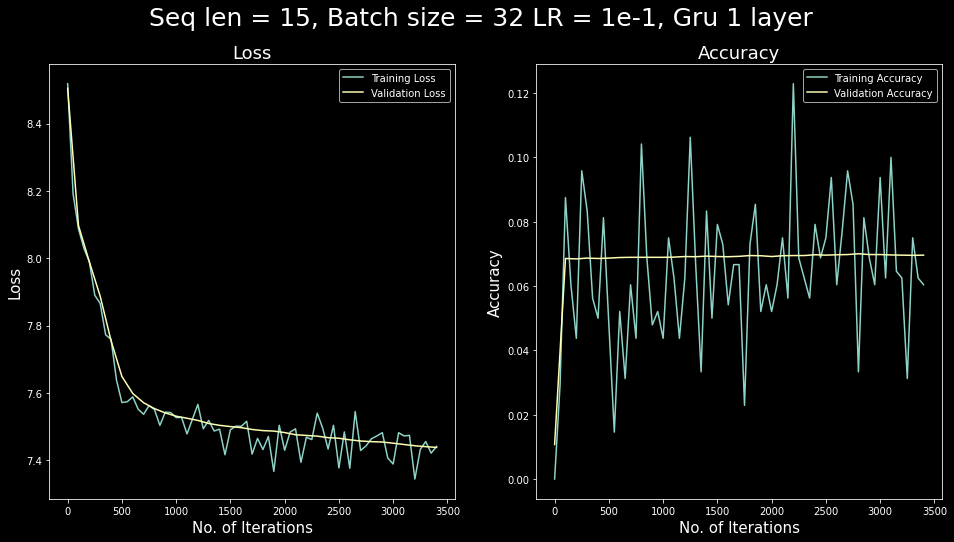

In [0]:
plot_training_log(training_log_1,title_suffix = 'LR = 1e-1, Gru 1 layer')

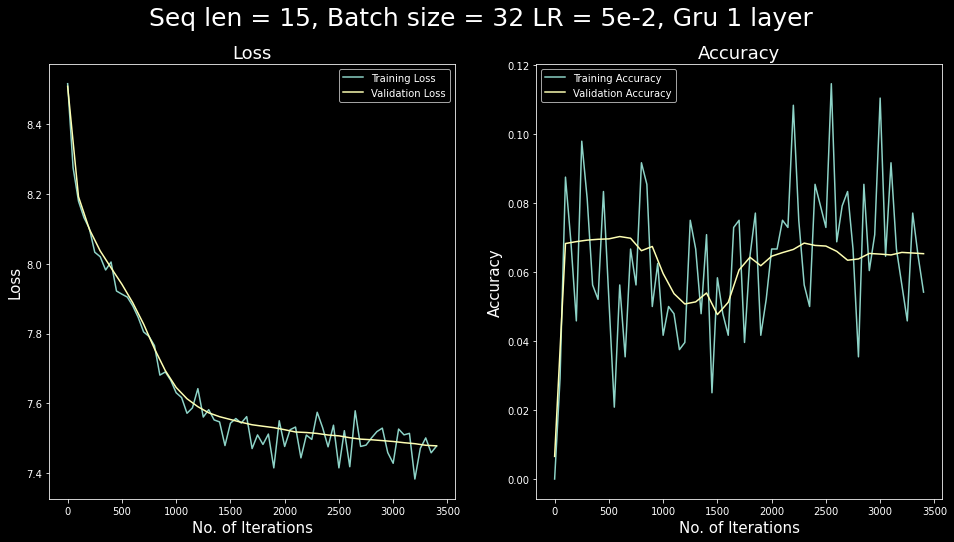

In [0]:
plot_training_log(training_log_2,title_suffix = 'LR = 5e-2, Gru 1 layer')

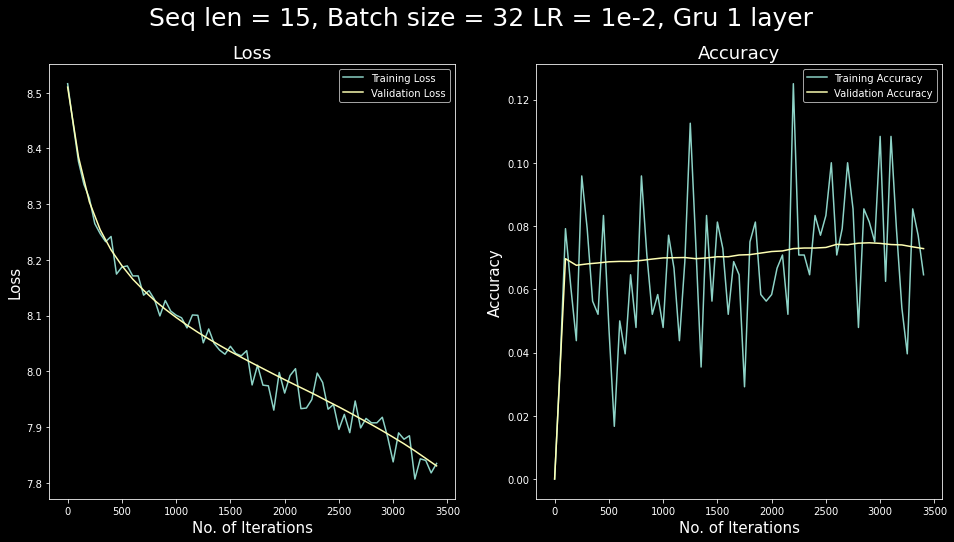

In [0]:
plot_training_log(training_log_3,title_suffix = 'LR = 1e-2, Gru 1 layer')

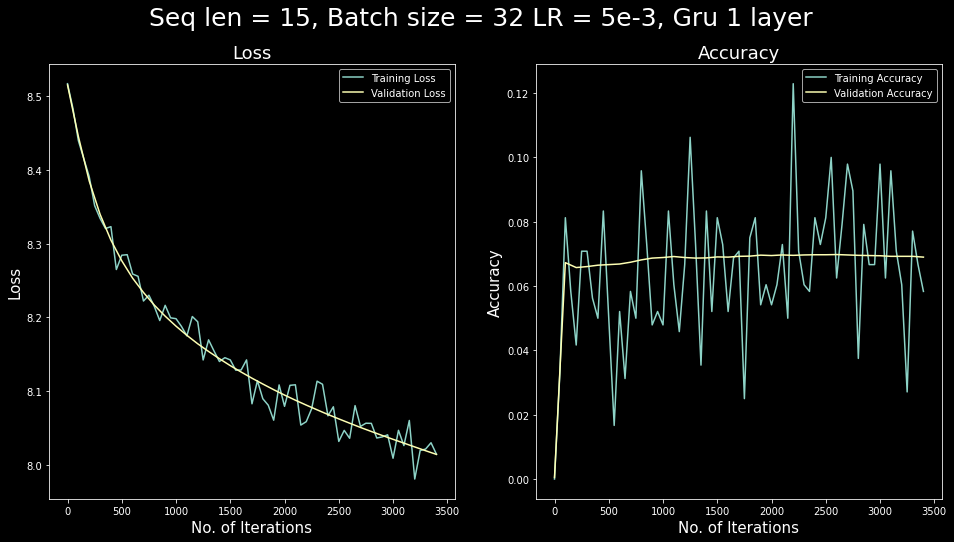

In [0]:
plot_training_log(training_log_4,title_suffix = 'LR = 5e-3, Gru 1 layer')

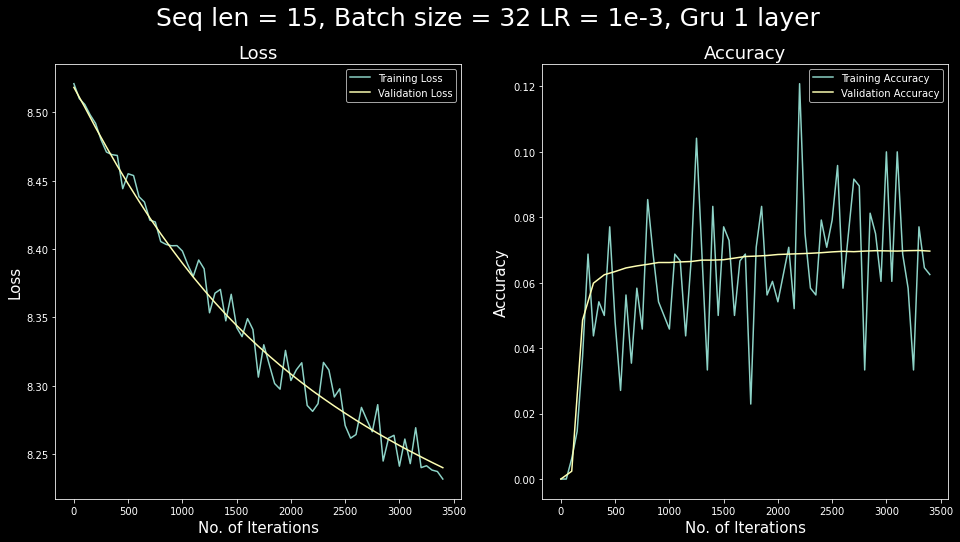

In [0]:
plot_training_log(training_log_5,title_suffix = 'LR = 1e-3, Gru 1 layer')

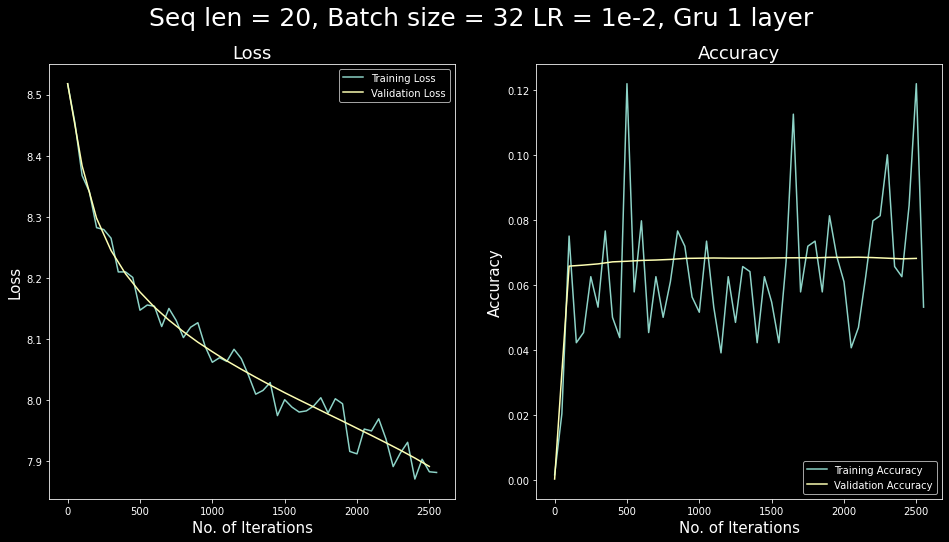

In [0]:
plot_training_log(training_log_6,title_suffix = 'LR = 1e-2, Gru 1 layer')

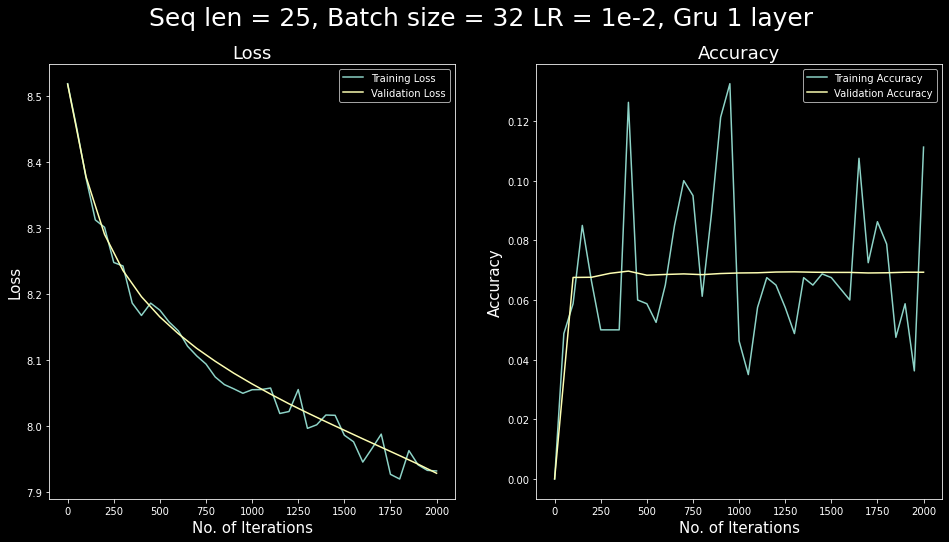

In [0]:
plot_training_log(training_log_7,title_suffix = 'LR = 1e-2, Gru 1 layer')

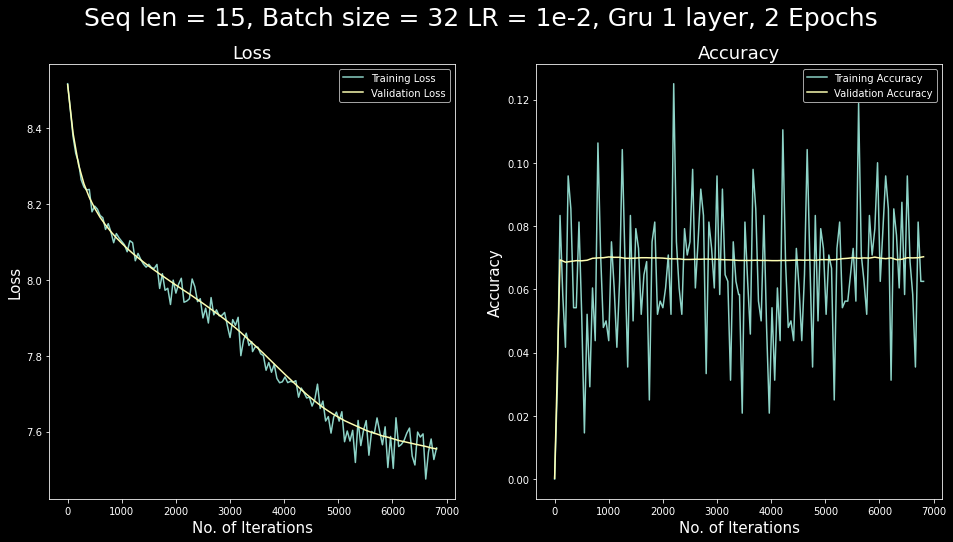

In [0]:
plot_training_log(training_log_8,title_suffix = 'LR = 1e-2, Gru 1 layer, 2 Epochs')

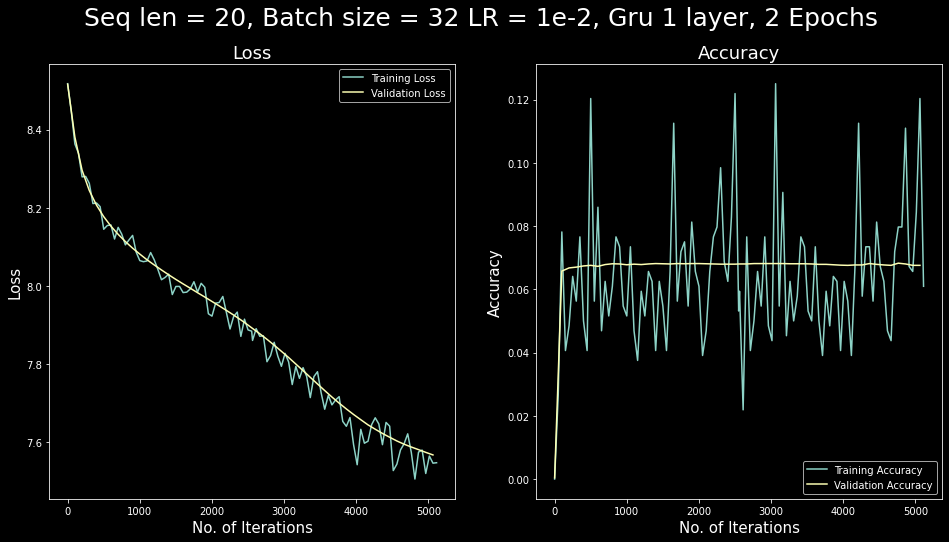

In [0]:
plot_training_log(training_log_9,title_suffix = 'LR = 1e-2, Gru 1 layer, 2 Epochs')

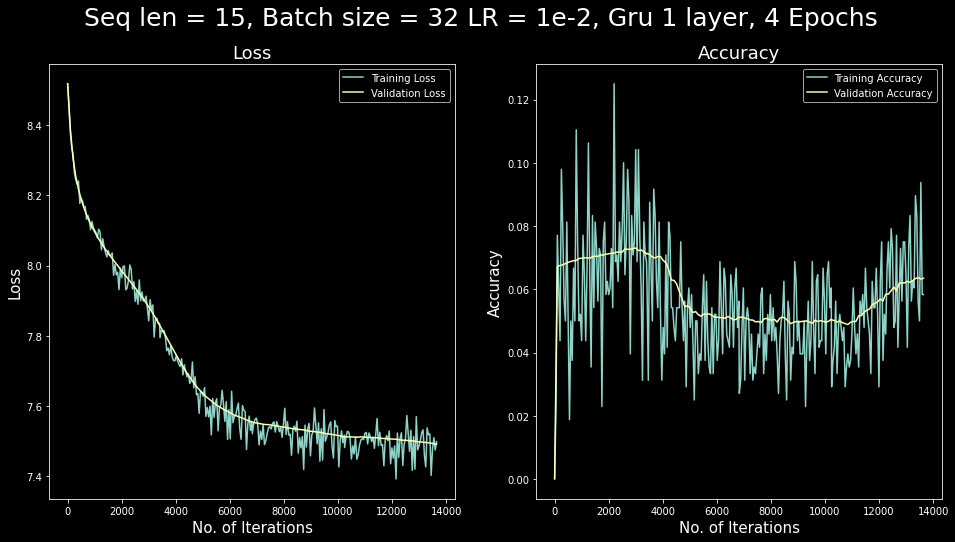

In [0]:
plot_training_log(training_log_10,title_suffix = 'LR = 1e-2, Gru 1 layer, 4 Epochs')

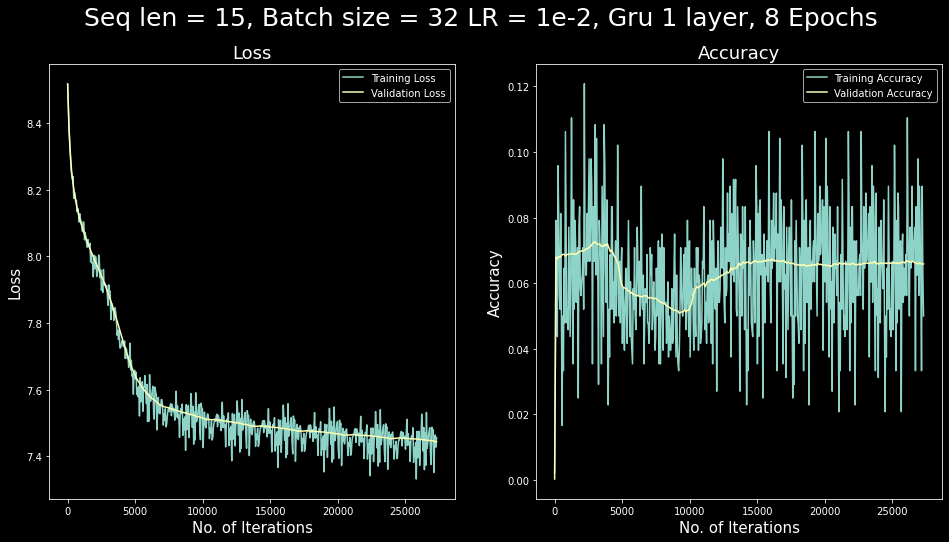

In [0]:
plot_training_log(training_log_11,title_suffix = 'LR = 1e-2, Gru 1 layer, 8 Epochs')

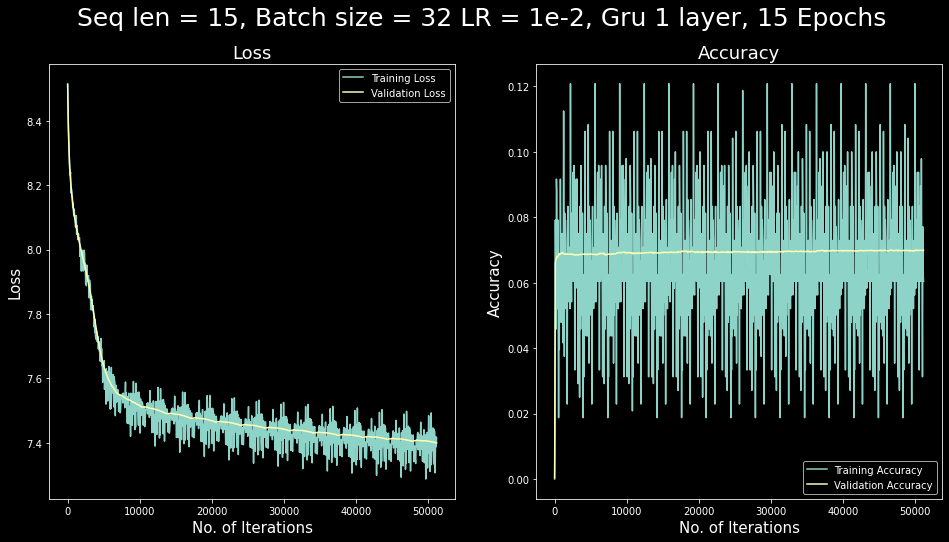

In [0]:
plot_training_log(training_log_12,title_suffix = 'LR = 1e-2, Gru 1 layer, 15 Epochs')

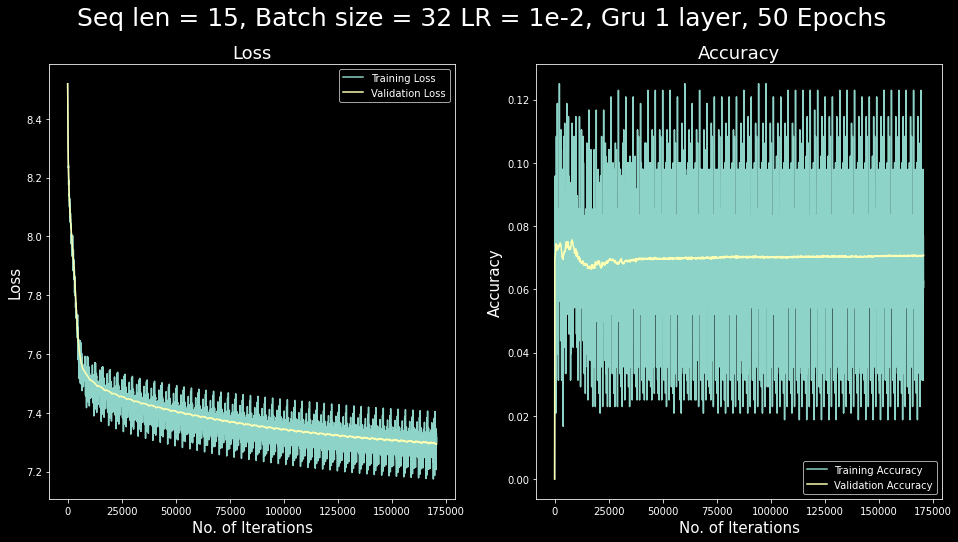

In [0]:
plot_training_log(training_log_13,title_suffix = 'LR = 1e-2, Gru 1 layer, 50 Epochs')

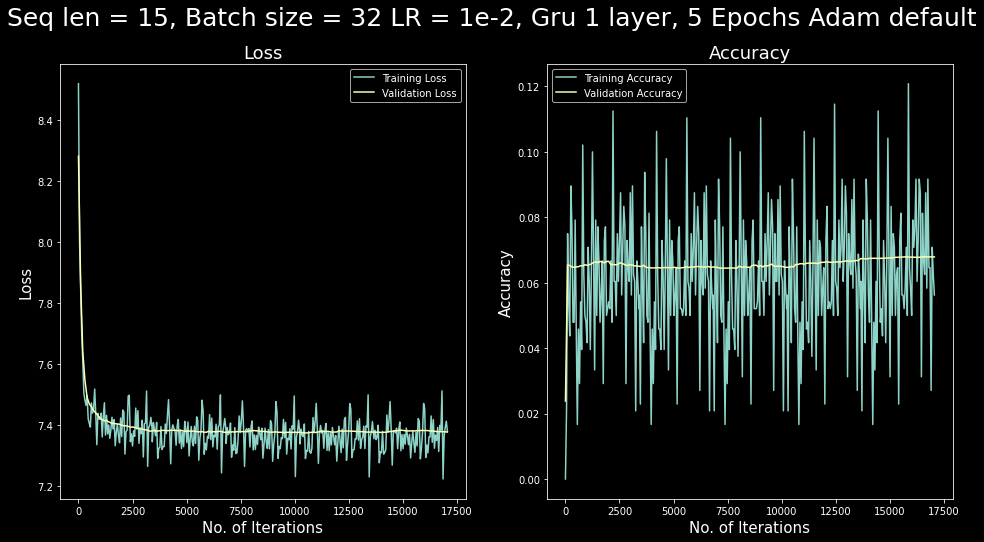

In [0]:
plot_training_log(training_log_14,title_suffix = 'LR = 1e-2, Gru 1 layer, 5 Epochs Adam default')

In [ ]:
def create_inputs(prompts, vocab):
    """Convert prompts from words into ids which can be then fed to the model

    Args:
        prompts (List of List of str): Prompts for speeches
        vocab (torchtext Vocab): vocabulary

    Returns:
        List of list of ints: Returns prompts back, with words converted 
        back into ids and and making all of them equal length
    """
    # prompt - list[list[str]]
    max_len = max([len(prompt) for prompt in prompts])
    prompts_uniform = [prompt[:max_len] for prompt in prompts]
    prompt_id = []
    for prompt in prompts:
        ids = []
        for word in prompt:
            ids.append(vocab.stoi[word])
        prompt_id.append(ids)
    return prompt_id

In [ ]:
def create_outputs(ids, vocab):
    """Covert output ids into a sentences

    Args:
        ids (List of list of ints): Output tokens of model in list format
        vocab (torchtext Vocab): Vocabulary

    Returns:
        List of str: Sentences
    """
    sents = []
    for id_list in ids:
        words = []
        for id in id_list:
            words.append(vocab.itos[id])
        sent = " ".join(words)
        sents.append(sent)
    return sents

In [ ]:
def write_speech(model, prompt, vocab, speech_len):
    """Generate text through greedy search

    Args:
        model (Model): model
        prompt (Tensor): Prompt in tensor form
        vocab (torchtext Vocab): Vocabulary
        speech_len (int): maximum speech length

    Returns:
        List of str: Generated speeches
    """
    model = model.eval()
    scores, state = model(prompt)
    _, preds_all = torch.max(scores, 2)
    preds = preds_all[:, -1].reshape(-1, 1)
    inputs = preds.clone()
    for i in range(speech_len):
        scores, state = model(preds, state)
        _, preds = torch.max(scores, 2)  # pred = pred[:,-1].reshape(-1,1)
        inputs = torch.cat((inputs, preds), 1)
    speeches = create_outputs(inputs, vocab)

    return speeches

In [ ]:
def write_speech_sampling(model,prompt,vocab,speech_len):
    """Generate speech by sampling from the indices with the probabilities calculated by the model

    Args:
        model (Model): model
        prompt (Tensor): Prompt in tensor form
        vocab (torchtext Vocab): Vocabulary
        speech_len (int): maximum speech length

    Returns:
        List of str: Generated speeches
    """
    model = model.eval()
    scores,states = model(prompt)
    _,preds_all = torch.max(scores,2)
    preds = preds_all[:,-1].reshape(-1,1)
    inputs = preds.cpu().detach().numpy()
    indices = np.array(range(4999))
    for i in range(speech_len):
        scores,states = model(preds,states)
        probs = F.softmax(scores,dim = 2).squeeze().cpu().detach().numpy()
        pred_list = []
        for row in probs:
            pred_index = np.random.choice(indices,p = row)
            pred_list.append(pred_index)
        pred_array = np.array(pred_list).reshape(-1,1)
        inputs = np.concatenate((inputs,pred_array),axis = 1)
        preds = torch.tensor(pred_array).to(device) 
           

    speeches = create_outputs(inputs,vocab)
        
    return speeches

In [19]:
def writes_speech_sampling_best_k(model, prompt, vocab, speech_len, k):
    """Generate speeches by sampling from top k words as per their normalized probability

    Args:
        model (Model): model
        prompt (Tensor): Prompt in tensor form
        vocab (torchtext Vocab): Vocabulary
        speech_len (int): maximum speech length
        k (int): sampling size

    Returns:
        List of str: Generated speeches
    """
    model = model.eval()
    batch_size, _ = prompt.shape
    prompt_array = prompt.cpu().detach().numpy()
    predictions = np.zeros((batch_size, 1), dtype=np.int16)
    for i in range(speech_len):
        # Calculating probabilities
        scores, states = model(prompt)
        scores_final = scores[:, -1:, :]
        probs = F.softmax(scores_final, dim=2).squeeze().cpu().detach().numpy()

        # Sorting indices as per their probabilities
        indexes_sorted = np.argsort(probs, axis=1)
        probs_sorted = np.sort(probs, axis=1)

        # Selecting best k indices and their probabilities and
        # then normalizing them so that sum of k probs is 1
        indexes_k_best = indexes_sorted[:, -k:]
        probs_k_best_unnorm = probs_sorted[:, -k:]
        probs_k_best = probs_k_best_unnorm / (
            probs_k_best_unnorm.sum(axis=1, keepdims=True)
        )
        pred_list = []

        for j in range(batch_size):
            indexes = indexes_k_best[j, :]
            probabs = probs_k_best[j, :]
            # Selecting indices in best k as per their normalized probabilities
            pred_index = np.random.choice(indexes, p=probabs)
            pred_list.append(pred_index)
        pred_array = np.array(pred_list).reshape(-1, 1)
        predictions = np.concatenate((predictions, pred_array), axis=1)
        prompt = torch.tensor(pred_array).to(device)

    speeches = create_outputs(predictions[:, 1:], vocab)

    return speeches

In [21]:
model_info =  torch.load('model_epoch_69.pt',map_location= device)

In [22]:
model = GRU_one_layer_Model(vocab)
model.load_state_dict(model_info['model_state_dict'])
model.to(device)

GRU_one_layer_Model(
  (embedding): Embedding(4999, 300)
  (gru): GRU(300, 4999, batch_first=True)
)

In [24]:
df_test = pd.read_excel('PM_MMS_Speech_test.xlsx',dtype={'title':'string',
                                               'date':'datetime64',
                                               'place':'string',
                                               'url':'string',
                                               'text':'string'})

In [26]:
df_test.head()

,title,date,place,url,text
0,PM's address to IPS Probationers,2010-01-05,New Delhi,https://archivepmo.nic.in/drmanmohansingh/spee...,"From your introductions, I am very encouraged ..."
1,Excerpts of address by the PM at the Combined ...,2010-09-13,New Delhi,https://archivepmo.nic.in/drmanmohansingh/spee...,The Nation is proud of the selfless devotion t...
2,PM's opening remarks at the All Party Meeting,2008-11-30,New Delhi,https://archivepmo.nic.in/drmanmohansingh/spee...,"""Esteemed Chairperson UPA, respected colleague..."
3,PM's address to the Nation,2014-05-17,New Delhi,https://archivepmo.nic.in/drmanmohansingh/spee...,"My Fellow Citizens, I address you today f..."
4,PM's opening remarks at the Full Planning Comm...,2011-04-21,New Delhi,https://archivepmo.nic.in/drmanmohansingh/spee...,"""This meeting of the Planning Commission has b..."


In [54]:
def create_prompt(string):
    return string.split()[:25]

In [ ]:
#creating prompts from test sets
df_test['prompt'] = df_test.text.apply(create_prompt)
all_prompts = list(df_test.prompt)
prompts = all_prompts[:4]
prompt = torch.tensor(create_inputs(prompts,vocab)).to(device)

In [78]:
#Using best k sampling to generate text
speeches_best_k = writes_speech_sampling_best_k(model,prompt,vocab,50,50)
start_lines =  create_outputs(prompt,vocab)
for i in range(4):
    print(start_lines[i])
    print('\n')
    print(textwrap.fill(speeches_best_k[i], 100))
    print('\n')
    print('- - - - - - - - - - - -  - - - --  -- - - - - -  -- - - - -  --  - --  - - - - - -')

From your <unk> I am very encouraged about the future of our <unk> I think you combine in yourself a vast amount of knowledge and


with our which development growth to from The people have new from is of growth at as need our you
all with as to at have be is also at which which and their <unk> at all , of I to can for people you
all people the also these


- - - - - - - - - - - -  - - - --  -- - - - - -  -- - - - -  --  - --  - - - - - -
The Nation is proud of the selfless <unk> to duty displayed by the officers and men and women in uniform and on behalf of the


we have development has we " be to must we country it development I with which with to and and from
have these from that our all not these has be , there an it , with I people more I as will we it
country more with We you


- - - - - - - - - - - -  - - - --  -- - - - - -  -- - - - -  --  - --  - - - - - -
<unk> Chairperson <unk> respected colleagues and <unk> I thank you all for being here at such short <unk> The <unk> at <un